In [1]:
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/code/src')
from skrgbd.calibration.camera_models.central_generic import CentralGeneric
from skrgbd.calibration.depth_distortion_models import load_from_pt, save_to_pt
from skrgbd.data.processing.processing_pipeline.depth.data_loaders import Loader, SLDataset
from skrgbd.data.dataset.scene_paths import ScenePaths
from skrgbd.utils.logging import tqdm
from skrgbd.calibration.depth_distortion_models.uv_d_cubic_bspline import UvDUndistortionModel
from skrgbd.data.dataset.dataset import wip_scene_id_by_name

In [2]:
cam = 'kinect_v2'

excluded_scenes = [
    # Transparent
    'plastic_micro_cover', 'orange_mini_vacuum', 'purple_iron',
    # Shiny 
    'steel_grater', 'white_toaster', 
]
scene_names = list(filter(lambda scene_name: scene_name not in excluded_scenes, wip_scene_id_by_name.keys()))

device, dtype = 'cuda', torch.double

### Load data

In [3]:
scene_paths = [ScenePaths(scene_name, aux_dir='/data/aux', data_dir='/data/dataset') for scene_name in scene_names]

cam_model = scene_paths[0].cam_model(cam, 'ir', 'generic')
cam_model = CentralGeneric(cam_model, dtype=dtype)
train_data = SLDataset(scene_paths, cam, cam_model)

  0%|          | 0/102 [00:00<?, ?it/s]

In [4]:
all_data = train_data.view_i, train_data.cos, train_data.raw_d, train_data.sl_d, train_data.uv

In [5]:
train_data.view_i, train_data.cos, train_data.raw_d, train_data.sl_d, train_data.uv = all_data

In [6]:
max_angle_deg = 45
mask = train_data.cos <= -np.cos(np.deg2rad(max_angle_deg))

mask = mask.logical_and_(train_data.view_i <= 11)  # only the bottom row

train_data.raw_d, train_data.sl_d, train_data.uv = train_data.raw_d[mask], train_data.sl_d[mask], train_data.uv[mask]

### Load wall undist model

In [7]:
undist_model = scene_paths[0].undist_model(cam, 'depth', 'wall')
undist_model = load_from_pt(undist_model).to(device, dtype)

### Compute base errors

In [8]:
def get_resids(sl_d, d):
    res = d.div(sl_d)
    res = res[res.isfinite()].sub_(1)
    return res

In [9]:
if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()

raw_resids = []
wall_resids = []

train_loader = Loader(train_data, batch_size=2**20, shuffle=False)
for uv, raw_d, sl_d in tqdm(train_loader):
    uv = uv.to(device, dtype)
    raw_d = raw_d.to(device, dtype)
    sl_d = sl_d.to(device, dtype)
    raw_resids.append(get_resids(sl_d, raw_d).cpu())
    d = undist_model(uv, raw_d.unsqueeze(1)); del uv, raw_d
    wall_resids.append(get_resids(sl_d, d).cpu()); del d, sl_d
raw_resids = torch.cat(raw_resids)
wall_resids = torch.cat(wall_resids)

  0%|          | 0/5 [00:00<?, ?it/s]

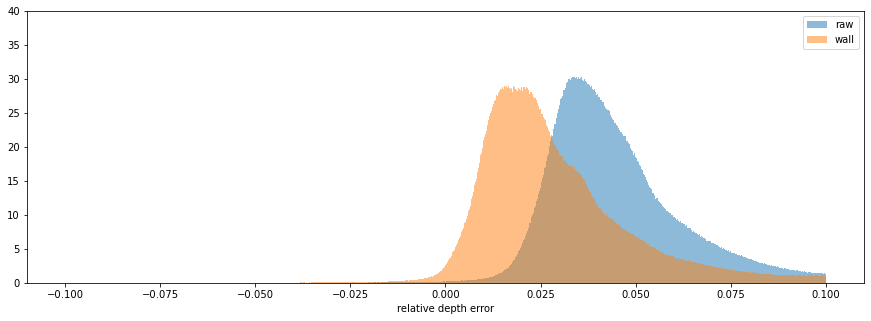

In [10]:
plt.figure(figsize=(15, 5))
kwargs = dict(bins=1000, range=(-.1, .1), alpha=.5, density=True)

plt.hist(raw_resids.numpy(), label='raw', **kwargs)
plt.hist(wall_resids.numpy(), label='wall', **kwargs)
plt.legend()
plt.gca().set_xlabel('relative depth error');
plt.ylim(0, 40);

### Tune model

  0%|          | 0/100 [00:00<?, ?it/s]

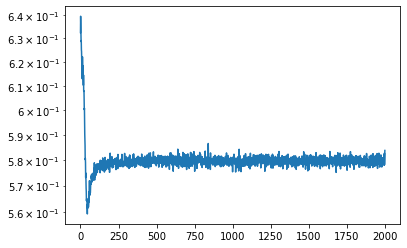

In [11]:
if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()

tune_model = torch.nn.Linear(1, 1, bias=False).to(device, dtype)
tune_model.weight.data.fill_(1)
if tune_model.bias is not None:
    tune_model.bias.data.fill_(0)
list(tune_model.parameters())

train_loader = Loader(train_data, batch_size=2**18, shuffle=True)


def fit_model(epochs_n=1, lr=1e-3):
    optim = torch.optim.Adam([*tune_model.parameters()], lr=lr)
    train_costs = []
    for epoch_i in tqdm(range(epochs_n)):
        for uv, raw_d, sl_d in train_loader:
            uv = uv.to(device, dtype)
            raw_d = raw_d.to(device, dtype)
            sl_d = sl_d.to(device, dtype)
            def closure():
                optim.zero_grad()
                d = undist_model(uv, raw_d.unsqueeze(1))
                is_valid = d.isfinite()
                d = tune_model(d[is_valid].unsqueeze(1)).squeeze(1)
                cost = cost_fn(sl_d[is_valid], d)
                cost.backward()
                train_costs.append(float(cost))
                return cost
            optim.step(closure); del uv, raw_d, sl_d
    return train_costs

max_res = .005
welsch_c = max_res / 3

def cost_fn(sl_d, d):
    res = d.div_(sl_d)
    res = res[res.isfinite()].sub_(1)
    res = res[res.abs() <= max_res]
    cost = welsch(res)
    return cost


def welsch(res):
    res = res.div(welsch_c).pow_(2).div_(-2)
    res = res.expm1_().neg()
    res = res.mean()
    return res


train_costs = fit_model(epochs_n=100, lr=3e-4)
tune_model = tune_model.requires_grad_(False)

plt.plot(train_costs)
plt.yscale('log')

### Compute tuned errors

In [12]:
if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()

undist_resids = []

train_loader = Loader(train_data, batch_size=2**20, shuffle=False)
for uv, raw_d, sl_d in tqdm(train_loader):
    uv = uv.to(device, dtype)
    raw_d = raw_d.to(device, dtype)
    sl_d = sl_d.to(device, dtype)
    d = undist_model(uv, raw_d.unsqueeze(1)); del uv, raw_d
    d = tune_model(d.unsqueeze(1)).squeeze(1)
    undist_resids.append(get_resids(sl_d, d).cpu()); del d, sl_d
undist_resids = torch.cat(undist_resids)

  0%|          | 0/5 [00:00<?, ?it/s]

Error distribution for filtered data.

[Parameter containing:
tensor([[0.9826]], device='cuda:0', dtype=torch.float64)]
Mode: -0.0017000000000000001


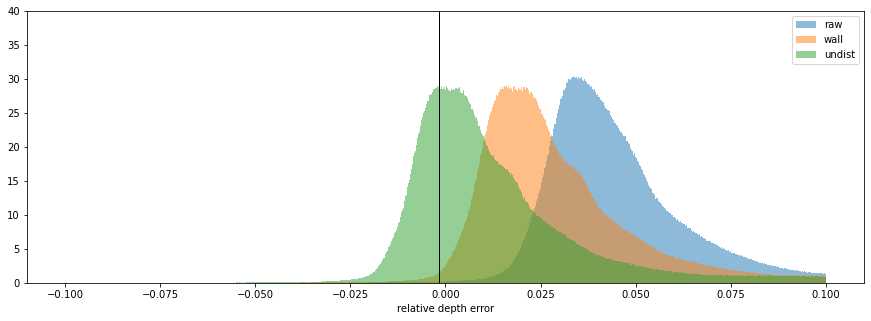

In [13]:
plt.figure(figsize=(15, 5))

plt.hist(raw_resids.numpy(), label='raw', **kwargs)
plt.hist(wall_resids.numpy(), label='wall', **kwargs)
undist_hist = plt.hist(undist_resids.numpy(), label='undist', **kwargs)
plt.legend()
plt.gca().set_xlabel('relative depth error');
plt.ylim(0, 40);

print(list(tune_model.parameters()))

mode_bin_i = undist_hist[0].argmax()
mode = (undist_hist[1][mode_bin_i] + undist_hist[1][mode_bin_i + 1]) / 2 
print(f'Mode: {mode}')
plt.vlines(mode, 0, 40, colors='k', linewidths=1);

Error distribution for all data.

In [14]:
train_data.view_i, train_data.cos, train_data.raw_d, train_data.sl_d, train_data.uv = all_data

if torch.device(device).type == 'cuda':
    torch.cuda.empty_cache()

raw_resids = []
wall_resids = []
undist_resids = []

train_loader = Loader(train_data, batch_size=2**20, shuffle=False)
for uv, raw_d, sl_d in tqdm(train_loader):
    uv = uv.to(device, dtype)
    raw_d = raw_d.to(device, dtype)
    sl_d = sl_d.to(device, dtype)
    raw_resids.append(get_resids(sl_d, raw_d).cpu())
    d = undist_model(uv, raw_d.unsqueeze(1)); del uv, raw_d
    wall_resids.append(get_resids(sl_d, d).cpu())
    d = tune_model(d.unsqueeze(1)).squeeze(1)
    undist_resids.append(get_resids(sl_d, d).cpu()); del d, sl_d

raw_resids = torch.cat(raw_resids)
wall_resids = torch.cat(wall_resids)
undist_resids = torch.cat(undist_resids)

  0%|          | 0/60 [00:00<?, ?it/s]

[Parameter containing:
tensor([[0.9826]], device='cuda:0', dtype=torch.float64)]
Mode: 0.008099999999999996


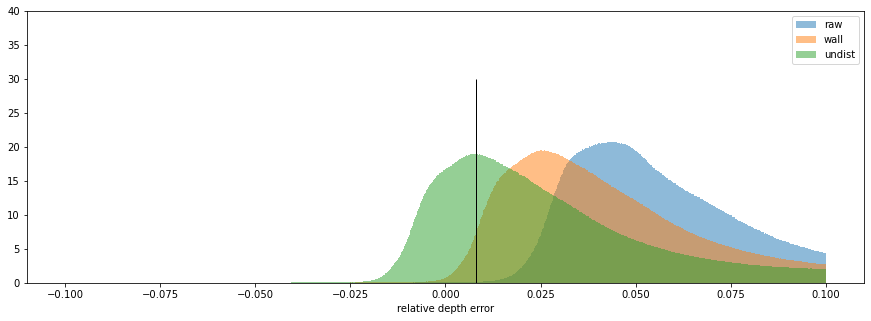

In [15]:
plt.figure(figsize=(15, 5))

plt.hist(raw_resids.numpy(), label='raw', **kwargs)
plt.hist(wall_resids.numpy(), label='wall', **kwargs)
undist_hist = plt.hist(undist_resids.numpy(), label='undist', **kwargs)
plt.legend()
plt.gca().set_xlabel('relative depth error');
plt.ylim(0, 40);

print(list(tune_model.parameters()))

mode_bin_i = undist_hist[0].argmax()
mode = (undist_hist[1][mode_bin_i] + undist_hist[1][mode_bin_i + 1]) / 2 
print(f'Mode: {mode}')
plt.vlines(mode, 0, 30, colors='k', linewidths=1);

### Save model

In [16]:
assert tune_model.bias is None
scaling_factor = float(tune_model.weight)
undist_model.d_spline.control_pts.data *= scaling_factor

tuned_model = UvDUndistortionModel.from_pb_model(undist_model.cpu(), cam_model)

In [17]:
tuned_model_pt = scene_paths[0].undist_model(cam, 'depth')
Path(tuned_model_pt).parent.mkdir(exist_ok=True, parents=True)
save_to_pt(tuned_model_pt, tuned_model)